<a href="https://colab.research.google.com/github/shramkoartem/automated-trading/blob/main/Trading_APIs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install tabula-py

     |████████████████████████████████| 6.3MB 7.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=b198f25c4164c48f572649ab8787d1706dd951b0a2bfbc4db5864b094df654e1
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 11.7MB 5.1MB/s 


In [ ]:
import yfinance as yf
import tabula

import math
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
#yf.Ticker("EBBB.PA").history(period='1D', interval='1m')


In [ ]:
# Ticker data sources:
# - https://www.alphavantage.co/documentation/

# Tutorial on yfinance https://algotrading101.com/learn/yfinance-guide/

## Generating list of traded ETF

In [ ]:
# Getting table of listed at Trade Republic ETFs
# ISIN & Name

path = "etfs.pdf"
tables = tabula.read_pdf(path, pages = "all", multiple_tables = True)

etfs = tables[0]

for i in range(1,len(tables)):
    if tables[i].shape[1] == 2 and tables[i].shape[0] < 50:
        print(tables[i].shape)
        etfs = pd.concat([etfs, tables[i]])

etfs.shape

In [ ]:
def get_ticker(isin):
    """
    Returns Ticker of a Stock based on the ISIN value
    - sends request to the yahoo finance api search
    - Ticker name is to be found in 'quotes'.0.'symbol'

    :Args:
        - isin (str) ISIN code of a stock
    :Returns:
        - Ticker (str)
    """

    url = "https://query2.finance.yahoo.com/v1/finance/search"  
    params = {'q': isin, 'quotesCount': 1, 'newsCount': 0}

    r = requests.get(url, params=params)
    if r.status_code == 200:
        data = r.json()
        try:
            ticker = data["quotes"][0]['symbol']
            return ticker
        except:
            print(data)
            return None
    else:
        print(r.status_code)


In [ ]:
# map Ticker names

etfs["Ticker"] = etfs["ISIN"].apply(lambda x: get_ticker(x))

In [ ]:
# Download generated file
from google.colab import files

etfs.to_csv("tr_etfs.csv")
files.download('tr_etfs.csv') 

## Getting historical data on portfolio

In [ ]:
# reading in data from the generated in prev step csv

filename = "tr_etfs.csv"

etfs = pd.read_csv(filename, index_col=0)

In [ ]:
etfs.head()

,ISIN,NOM,Ticker
0,LU1525418643,AMUNDI BARCLAYS EURO CORP BBB 1-5Y EUR (ACC),EBBB.PA
1,LU1437024729,AMUNDI BARCLAYS GLOBAL AGG 500M EUR (ACC),GAGU.AS
2,LU1708330318,AMUNDI BARCLAYS GLOBAL AGG 500M EUR (ACC),GAGH.PA
3,LU1737654019,AMUNDI BARCLAYS GLOBAL AGG 500M EUR (DIST),10AM.DE
4,LU1778293313,AMUNDI BARCLAYS GLOBAL AGG 500M USD (ACC),GAHU.PA


In [ ]:
yf.Ticker("A0YE.DG").info

{'logo_url': ''}

In [ ]:
port_isin = """IE00B5BMR087
IE00B4L5Y983
IE00BGV5VN51
IE00B3WJKG14
IE00BYZK4883
IE00BP3QZ825
LU1681045370
DE000A0KRJU0
LU1781541179""".split("\n")

In [ ]:
portfolio = etfs[etfs.ISIN.isin(port_isin)]

In [ ]:
positions = {'IE00B5BMR087': 2,
 'IE00B4L5Y983': 4,
 'IE00BGV5VN51': 3,
 'IE00B3WJKG14': 15,
 'IE00BYZK4883': 12,
 'IE00BP3QZ825': 2,
 'LU1681045370': 20,
 'LU1781541179': 5}

In [ ]:
portfolio["n"] = portfolio["ISIN"].apply(lambda x: positions.get(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
portfolio

,ISIN,NOM,Ticker,n
44,LU1681045370,AMUNDI MSCI EMERGING MARKETS EUR (ACC),AEEM.PA,20
20,IE00B4L5Y983,ISHARES CORE MSCI WORLD USD (ACC),IWDA.L,4
21,IE00B5BMR087,ISHARES CORE S&P 500 USD (ACC),CSSPX.MI,2
30,IE00BYZK4883,ISHARES DIGITALISATION USD (ACC),DGIT.L,12
35,IE00BP3QZ825,ISHARES EDGE WORLD MOMENTUM USD (ACC),IWFM.L,2
16,IE00B3WJKG14,ISHARES S&P 500 INFORMATION TECH USD (ACC),IITU.L,15
6,LU1781541179,LYXOR CORE MSCI WORLD USD (ACC),LCWL.L,5
44,IE00BGV5VN51,XTRACKERS AI & BIG DATA USD (ACC),IE00BGV5VN51.SG,3


In [ ]:
def get_open(x):
    try:
        return yf.Ticker(x).info["open"]
    except:
        return 0


In [ ]:
portfolio["open"] = portfolio["Ticker"].apply(lambda x: get_open(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
portfolio

,ISIN,NOM,Ticker,n,open
44,LU1681045370,AMUNDI MSCI EMERGING MARKETS EUR (ACC),AEEM.PA,20,5.1002
20,IE00B4L5Y983,ISHARES CORE MSCI WORLD USD (ACC),IWDA.L,4,81.8400
21,IE00B5BMR087,ISHARES CORE S&P 500 USD (ACC),CSSPX.MI,2,350.7400
30,IE00BYZK4883,ISHARES DIGITALISATION USD (ACC),DGIT.L,12,751.7500
35,IE00BP3QZ825,ISHARES EDGE WORLD MOMENTUM USD (ACC),IWFM.L,2,4414.0000
16,IE00B3WJKG14,ISHARES S&P 500 INFORMATION TECH USD (ACC),IITU.L,15,1229.0000
6,LU1781541179,LYXOR CORE MSCI WORLD USD (ACC),LCWL.L,5,10.5680
44,IE00BGV5VN51,XTRACKERS AI & BIG DATA USD (ACC),IE00BGV5VN51.SG,3,0.0000


## Getting historical data

In [ ]:
tic_names = portfolio.Ticker.values.tolist()
tic_names.remove("IE00BGV5VN51.SG")
tickers = yf.Tickers(tic_names)

In [ ]:
tics_daily = tickers.history('max')[["Close", "High", "Low", "Open", "Volume"]]

[*********************100%***********************]  7 of 7 completed


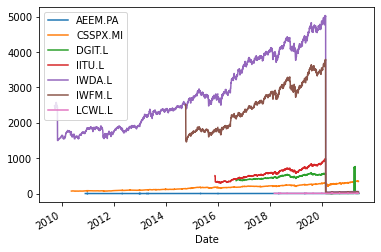

In [ ]:
tics_daily["Close"].plot()

In [ ]:
def calculate_returns(close):
    """
    Compute returns for each ticker and date in close.
    
    Parameters
    ----------
    close : DataFrame
        Close prices for each ticker and date
    
    Returns
    -------
    returns : DataFrame
        Returns for each ticker and date
    """
    # TODO: Implement Function
    
    return (close - close.shift(1))/close.shift(1)

tic_r =  calculate_returns(tics_daily.Close)

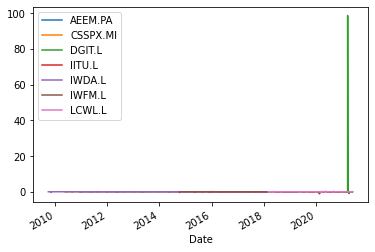

In [ ]:
tic_r.plot()

In [ ]:
def get_zscore(df):
    for col in df.columns:
        df[col] = (df[col] - df[col].mean()) / df[col].std(ddof=0)

    return df

In [ ]:
scores = get_zscore(tic_r) < 3

clean_tic_r = tic_r[scores.all(axis=1)]


In [ ]:
clean_tic_r.tail(20)

,AEEM.PA,CSSPX.MI,DGIT.L,IITU.L,IWDA.L,IWFM.L,LCWL.L
Date,,,,,,,
2021-04-22,0.633829,0.573003,-0.024033,0.331024,0.532272,0.544030,0.788891
2021-04-23,0.350605,-0.445931,-0.028329,0.029428,0.038176,0.039148,0.040520
2021-04-26,-0.051235,0.162196,-0.027274,0.128698,0.061544,0.112206,0.115577
2021-04-27,0.238222,-0.216438,-0.027448,-0.187060,-0.207269,-0.076052,-0.334344
2021-04-28,0.144135,-0.079470,-0.030758,-0.250309,0.104777,-0.053172,0.147329
2021-04-29,-0.546172,-0.145351,-0.032153,-0.239721,-0.114052,-0.195732,-0.172370
2021-04-30,-0.450355,0.360100,-0.030059,0.086741,0.198710,0.147768,0.297993
2021-05-05,1.066910,1.023934,-0.027207,0.304636,0.414411,0.420889,0.555116
2021-05-06,0.055193,-0.619503,-0.033839,-0.053270,0.022661,-0.304165,0.059632


(-10.0, 10.0)

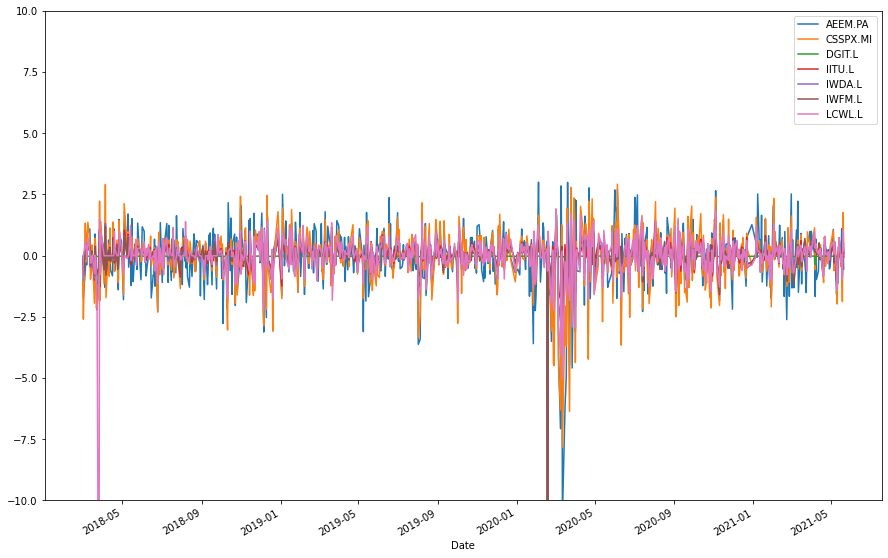

In [ ]:
clean_tic_r.plot(figsize=(15,10))

plt.ylim(-10, 10)

In [ ]:
get_zscore(tic_r).max()

AEEM.PA      6.678395
CSSPX.MI     7.752727
DGIT.L      34.186909
IITU.L       2.512280
IWDA.L       2.913367
IWFM.L       2.280790
LCWL.L       4.286523
dtype: float64

In [ ]:
clean_tic_r.abs().max()

AEEM.PA     10.653474
CSSPX.MI     7.830786
DGIT.L       0.372468
IITU.L      31.752002
IWDA.L      44.981283
IWFM.L      34.906551
LCWL.L      19.571694
dtype: float64

In [ ]:
get_zscore(tic_r) <3

,AEEM.PA,CSSPX.MI,DGIT.L,IITU.L,IWDA.L,IWFM.L,LCWL.L
Date,,,,,,,
2009-09-25,False,False,False,False,False,False,False
2009-09-28,False,False,False,False,True,False,False
2009-09-29,False,False,False,False,True,False,False
2009-09-30,False,False,False,False,True,False,False
2009-10-01,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...
2021-05-24,True,False,False,False,False,False,False
2021-05-25,True,False,False,False,False,False,False
2021-05-26,True,False,False,False,False,False,False


In [ ]:
tic_corr = tic_r.corr()

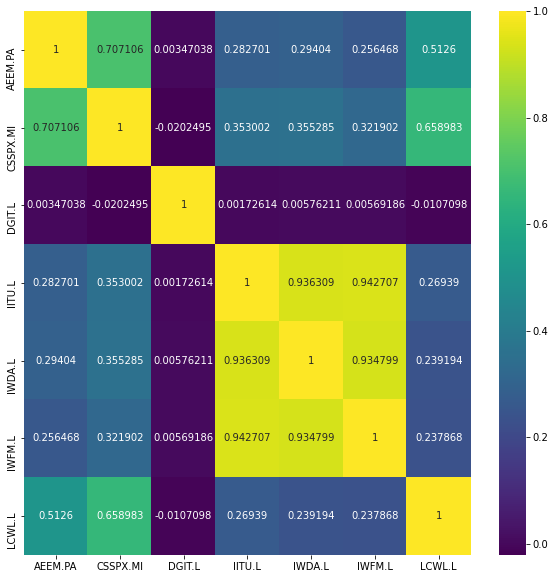

In [ ]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(tic_corr, annot=True, fmt="g", cmap='viridis')
plt.show()

In [ ]:
portfolio

,ISIN,NOM,Ticker,n,open
44,LU1681045370,AMUNDI MSCI EMERGING MARKETS EUR (ACC),AEEM.PA,20,5.1002
20,IE00B4L5Y983,ISHARES CORE MSCI WORLD USD (ACC),IWDA.L,4,81.8400
21,IE00B5BMR087,ISHARES CORE S&P 500 USD (ACC),CSSPX.MI,2,350.7400
30,IE00BYZK4883,ISHARES DIGITALISATION USD (ACC),DGIT.L,12,751.7500
35,IE00BP3QZ825,ISHARES EDGE WORLD MOMENTUM USD (ACC),IWFM.L,2,4414.0000
16,IE00B3WJKG14,ISHARES S&P 500 INFORMATION TECH USD (ACC),IITU.L,15,1229.0000
6,LU1781541179,LYXOR CORE MSCI WORLD USD (ACC),LCWL.L,5,10.5680
44,IE00BGV5VN51,XTRACKERS AI & BIG DATA USD (ACC),IE00BGV5VN51.SG,3,0.0000


In [ ]:
tic_r.tail(100).fillna(0).cumsum()

,AEEM.PA,CSSPX.MI,DGIT.L,IITU.L,IWDA.L,IWFM.L,LCWL.L
Date,,,,,,,
2021-01-07,-0.072225,0.769012,-0.028124,0.294721,0.365722,0.542499,0.541754
2021-01-08,2.442312,1.096761,-0.051223,0.419890,0.513629,0.989255,0.737650
2021-01-11,2.548683,1.698983,-0.079936,0.571147,0.611623,1.056703,0.899876
2021-01-12,3.187626,1.492512,-0.110660,0.007170,0.142243,0.585903,0.211468
2021-01-13,3.068446,1.615299,-0.137524,0.234491,0.216135,0.693917,0.281797
...,...,...,...,...,...,...,...
2021-05-24,-0.756826,5.536607,31.195352,1.706333,2.875809,1.648458,3.441075
2021-05-25,-0.177190,5.536607,31.195352,1.706333,2.875809,1.648458,3.441075
2021-05-26,0.557900,5.536607,31.195352,1.706333,2.875809,1.648458,3.441075
